In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
images = np.load("train/images.npy").astype(np.float32) / 255
labels = np.load("train/labels.npy").astype(np.uint8)
encoded = np.load("train/encoded.npy").astype(np.uint8)

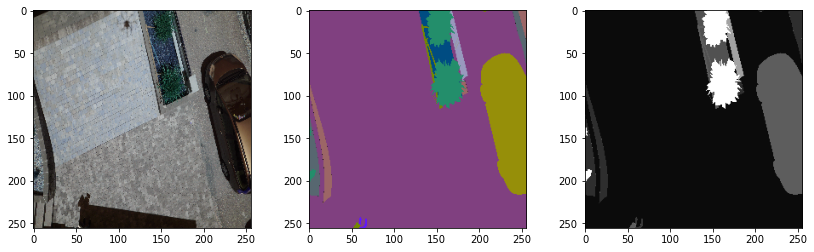

In [3]:
fig,axes = plt.subplots(1,3,figsize=(14,4))

i = np.random.randint(len(images))

axes[0].imshow(images[i])
axes[1].imshow(labels[i])
axes[2].imshow(encoded[i].argmax(axis=2) / 24,cmap="gray")

### UNet

In [5]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,Callback,ModelCheckpoint

In [59]:
_input = Input(shape=(256,256,3))

b1_conv = Conv2D(32,3,activation="relu",padding="same")(_input)
b1_conv = Conv2D(32,3,activation="relu",padding="same")(b1_conv)
b1_conv = Conv2D(32,3,activation="relu",padding="same")(b1_conv)
b1_pool = MaxPool2D()(b1_conv)
b1_batch = BatchNormalization()(b1_pool)
## 128x128

b2_conv = Conv2D(64,3,activation="relu",padding="same")(b1_batch)
b2_conv = Conv2D(64,3,activation="relu",padding="same")(b2_conv)
b2_conv = Conv2D(64,3,activation="relu",padding="same")(b2_conv)
b2_pool = MaxPool2D()(b2_conv)
b2_batch = BatchNormalization()(b2_pool)
## 64x64

b3_conv = Conv2D(128,3,activation="relu",padding="same")(b2_batch)
b3_conv = Conv2D(128,3,activation="relu",padding="same")(b3_conv)
b3_conv = Conv2D(128,3,activation="relu",padding="same")(b3_conv)
b3_pool = MaxPool2D()(b3_conv)
b3_batch = BatchNormalization()(b3_pool)
## 32x32

b3a_conv = Conv2D(256,3,activation="relu",padding="same")(b3_batch)
b3a_conv = Conv2D(256,3,activation="relu",padding="same")(b3a_conv)
b3a_conv = Conv2D(256,3,activation="relu",padding="same")(b3a_conv)
b3a_pool = MaxPool2D()(b3a_conv)
b3a_batch = BatchNormalization()(b3a_pool)
## 16x16


bn_conv = Conv2D(512,1,activation="relu",padding="same")(b3a_batch)
bn_batch = BatchNormalization()(bn_conv)
bn_conv = Conv2D(512,1,activation="relu",padding="same")(bn_batch)
## 16x16

b4a_conv = Conv2D(256,3,activation="relu",padding="same")(concatenate([b3a_batch,bn_conv]))
b4a_conv = Conv2D(256,3,activation="relu",padding="same")(b4a_conv)
b4a_conv = Conv2DTranspose(128,3,activation="relu",strides=2,padding="same")(b4a_conv)
b4a_batch = BatchNormalization()(b4a_conv)
## 32x32

b4_conv = Conv2D(128,3,activation="relu",padding="same")(concatenate([b3_batch,b4a_batch]))
b4_conv = Conv2D(128,3,activation="relu",padding="same")(b4_conv)
b4_conv = Conv2DTranspose(128,3,activation="relu",strides=2,padding="same")(b4_conv)
b4_batch = BatchNormalization()(b4_conv)
## 64x64

b5_conv = Conv2D(64,3,activation="relu",padding="same")(concatenate([b2_batch,b4_batch]))
b5_conv = Conv2D(64,3,activation="relu",padding="same")(b5_conv)
b5_conv = Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(b5_conv)
b5_batch = BatchNormalization()(b5_conv)
## 128x128

b6_conv = Conv2D(32,3,activation="relu",padding="same")(concatenate([b1_batch,b5_batch]))
b6_conv = Conv2D(32,3,activation="relu",padding="same")(b6_conv)
b6_conv = Conv2DTranspose(32,3,activation="relu",strides=2,padding="same")(b6_conv)
b6_batch = BatchNormalization()(b6_conv)
## 256x256

out = Conv2D(24,1,padding="same")(b6_batch)
out = BatchNormalization()(out)
out = Reshape((-1,24))(out)
train_out = Activation("softmax")(out)
    
segnet = keras.Model(_input,out)
train = keras.Model(_input,train_out)

In [60]:
train.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 256, 256, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_111[0][0]                 
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_112[0][0]                 
____________________________________________________________________________________________

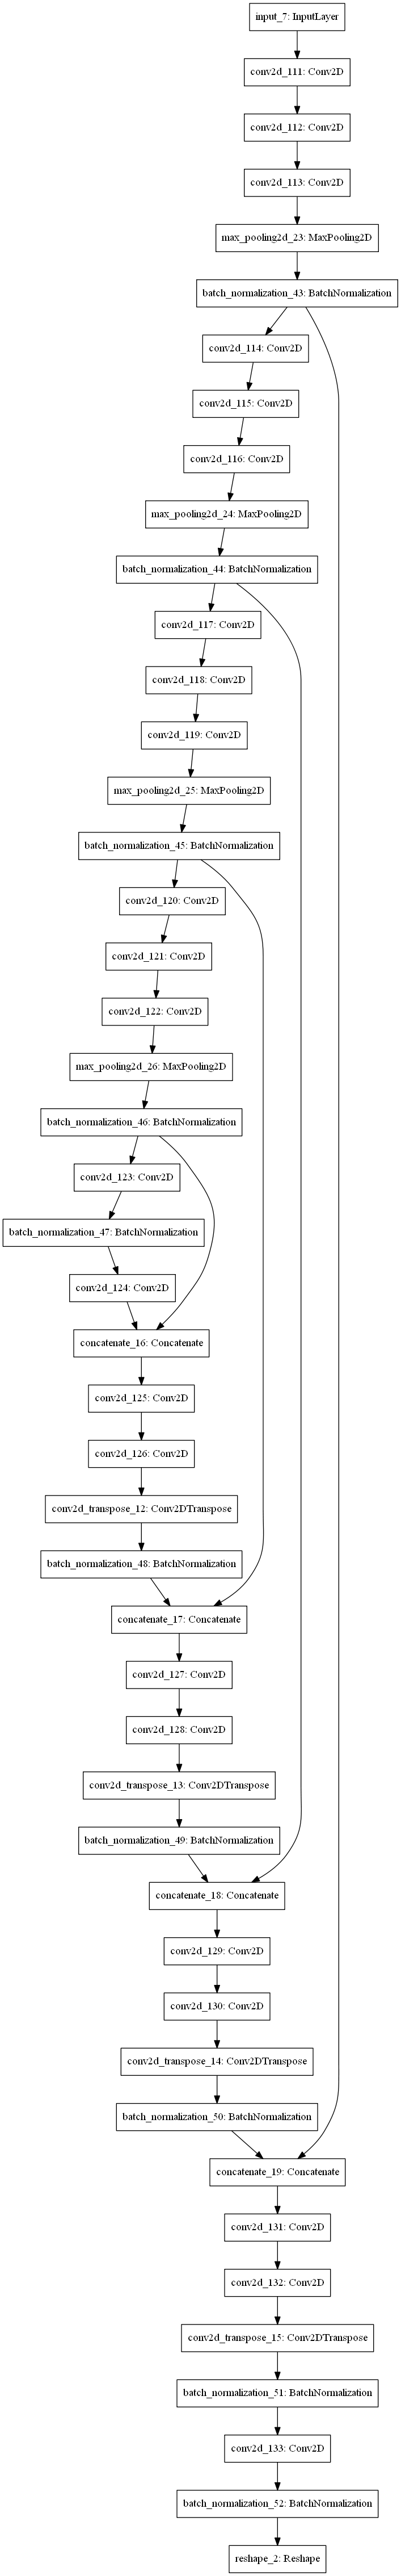

In [61]:
keras.utils.plot_model(segnet)

In [62]:
%%time

for i in range(24):
    train(images[i:i+1])

Wall time: 1.91 s


In [63]:
class EpochSaver(Callback):
    """
    Saves Predicted Image Every Epoch
    """
    def __init__(self,path):
        self.path = path
        
    def on_epoch_end(self,epoch,logs=None,*args,**kwargs):    
        epoch += 221
        fig,axes = plt.subplots(2,2,figsize=(14,14))
        pred = self.model.predict(images[0:1])[0].reshape(256,256,24).argmax(axis=2)
        
        axes[0,0].imshow(images[i])
        axes[0,1].imshow(labels[i])
        axes[1,0].imshow(encoded[i].reshape(256,256,24).argmax(axis=2) / 24,cmap="gray")
        axes[1,1].imshow(pred / 24,cmap="gray")
        fig.savefig(f"{self.path}/{epoch}.jpg")
        
        plt.cla()
        plt.close()
        

In [64]:
def schedule(epoch,*args,**kwargs):
    epoch += 221
    if epoch > 325:
        return .00001
    elif epoch > 175:
        return .0001
    elif epoch > 100:
        return .001
    else:
        return .00001    

In [65]:
lrs = LearningRateScheduler(schedule=schedule)
se = EpochSaver("./doc/epochs/unet")
chk = ModelCheckpoint(filepath="./checkpoints/unet",monitor="loss",save_freq="epoch",save_weights_only=True)

In [66]:
opt = keras.optimizers.Adam()

In [67]:
train.compile(optimizer=opt,loss="categorical_crossentropy")

In [68]:
encoded = encoded.reshape((len(encoded),-1,24))

In [88]:
# train.load_weights("checkpoints/unet")

In [89]:
history = train.fit(images,encoded,batch_size=1,epochs=400,callbacks=[lrs,se,chk])

Train on 400 samples
Epoch 1/400
400/400 [==============================] - 52s 130ms/sample - loss: 2.8132
Epoch 2/400
292/400 [====================>.........] - ETA: 14s - loss: 2.5180

KeyboardInterrupt: 

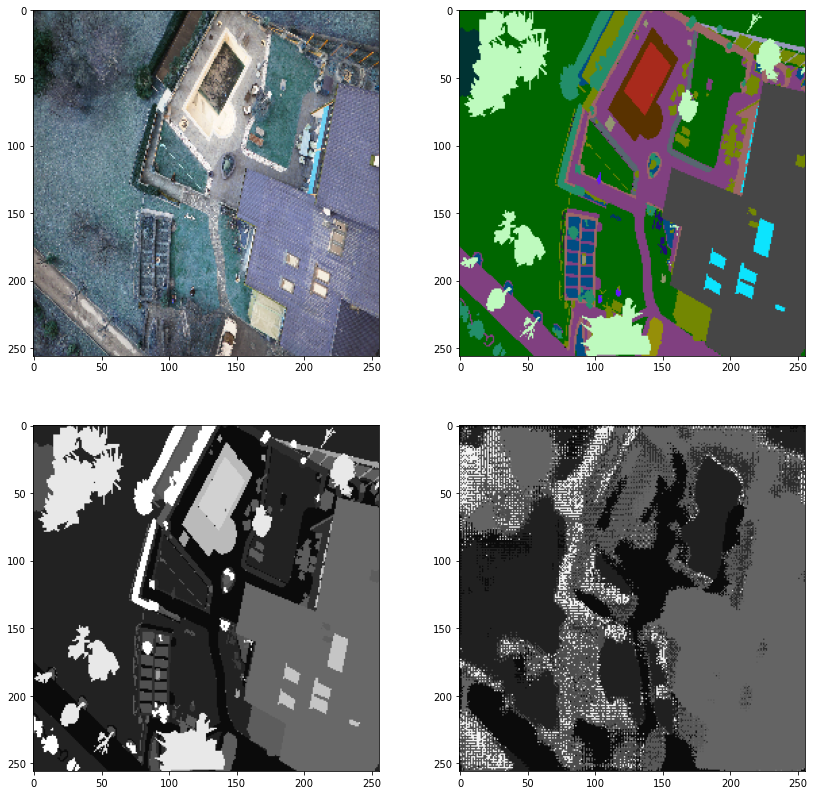

In [94]:
fig,axes = plt.subplots(2,2,figsize=(14,14))
i = np.random.randint(len(images))

pred = segnet.predict(images[i:i+1])[0].argmax(axis=1).reshape(256,256)

axes[0,0].imshow(images[i])
axes[0,1].imshow(labels[i])
axes[1,0].imshow(encoded[i].reshape(256,256,-1).argmax(axis=2) / 24,cmap="gray")
axes[1,1].imshow(pred / 24,cmap="gray")

In [73]:
pred = segnet.predict(images[i:i+1])